In [351]:
import os
import sys
import wget
import json
import gzip
import re
import json
import numpy as np
import pandas as pd
import annoy
from itertools import chain
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from google.cloud import vision
from google.cloud.vision import types
from google.protobuf.json_format import MessageToDict
from sklearn.preprocessing import StandardScaler
from annoy import AnnoyIndex
from collections import Counter
from sklearn.decomposition import PCA as sklearnPCA
import matplotlib.pyplot as plt
import seaborn

pd.set_option('max_colwidth', 400)

In [525]:
# Download and process data, including retrieval of images:
# initial_product_data_prep_and_image_retrieval

# Load prepared filtered pickle
df = pd.read_pickle("filtered_with_image_labels.pkl")

print(df.count()) 
print(df.iloc[10])

asin                1152
title               1152
brand               1152
description         1152
image               1152
feature             1152
category            1152
similar_item        1152
also_buy             494
also_view            806
adj_title           1152
image_labels        1152
adj_brand           1152
category_filt       1152
similar_item_ids    1152
document            1152
title_length        1152
document2           1152
dtype: int64
asin                                                                                                                                                                                                                                                                                                                                                                                                                     B002SGHTUS
title                                                                                                                

In [507]:
# Create vectorizer. We won't be using TF-IDF, not going to adjust for common words/stop words. 
# If we incorporated the narrative description of the product this would be a good thing to do.
vectorizer = CountVectorizer()

X = vectorizer.fit_transform(df['document'])
print(vectorizer.get_feature_names()[0:100])

# Output the shape of matrix
print(X.shape)

# Compute the cosine similarity matrix
cosine_sim = cosine_similarity(X)

print(cosine_sim.shape)

cosine_sim[0]

['05', '10', '100', '11', '114cm', '120cm', '15', '180s', '18mm', '1crepprotectcureultimatecleaningsolution', '2018', '22', '23', '245', '24kgoldtonefinishoverbrassmakesthislooks', '2mm', '2t', '30', '30cm', '37', '38', '3inch', '3xl', '43kg', '44', '47', '47mm', '4t', '50', '56cm', '5ozimprovedcleaningsolution', '5t', '5x', '6mm', '78cm', '7cm', '81stgeneration', '8inch', '925sterlingsilver', '98', '9inch', 'aa', 'aaa', 'aar', 'abalone', 'abaya', 'abdomen', 'abearth', 'academiccertificate', 'accented', 'accessories', 'accessoriesforever', 'acevog', 'acrossbody', 'acrylic', 'active', 'activepants', 'activeproducts', 'activeshirt', 'activetank', 'activeusa', 'adapter', 'adelaqueen', 'adimani', 'adjustable', 'adjustabledrawstring', 'adorned', 'aerosol', 'affirmation', 'african', 'africanplanet', 'afterall', 'agentprovocateur', 'agreatgiftforyourloveroryourself', 'ainimoer', 'aireefairee', 'aisa', 'alabone', 'albumcover', 'alchemygothic', 'alien', 'alilang', 'all', 'allbeauty', 'allntrend

array([1.        , 0.12249899, 0.16198477, ..., 0.17036708, 0.25162996,
       0.43463356])

In [509]:
# Principal Component Analysis (PCA) to reduce dimensionality

titles = df['title'].copy().tolist()
cosine_df = pd.DataFrame(data=cosine_sim, index=titles)
cosine_df.head()

# Standardize values from cosine similarity matrix
X_std = StandardScaler().fit_transform(cosine_df)

# Covariance matrix
cov_mat = np.cov(X_std.T)

# Perform eigendecomposition on covariance matrix
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

pca = sklearnPCA(n_components=40)
pca.fit_transform(cosine_df)
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.47771713 0.18559824 0.11635727 0.04591045 0.02373281 0.01652508
 0.01476489 0.01180903 0.00927104 0.00797699 0.00662258 0.00593589
 0.0053144  0.00429489 0.00379516 0.00359521 0.00341908 0.00314528
 0.00267627 0.0024658  0.0022702  0.00188149 0.00180378 0.00160241
 0.00156671 0.00143526 0.00140381 0.00129286 0.00119121 0.00115371
 0.00103988 0.00097772 0.00097083 0.00091641 0.00085011 0.00082639
 0.00077152 0.00075568 0.00074048 0.00069484]
0.9750727808218703


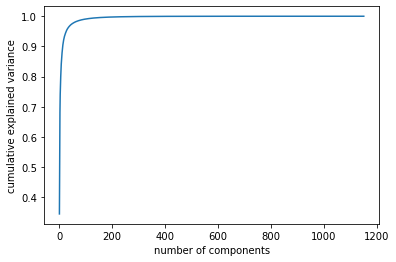

In [449]:
# Explained variance
pca = sklearnPCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [511]:
# Prep final model
pca = sklearnPCA(n_components=40)
pca_output = pca.fit_transform(X_std)
pca_output.shape

(1152, 40)

In [514]:
# Use pca_output as input to annoy
f = pca_output.shape[1]
t = AnnoyIndex(f, 'angular')
for i in range(pca_output.shape[0]):
    v = pca_output[i]
    t.add_item(i, v)
    
t.build(20) # 10 trees
t.save('product_similarity.ann')

u = AnnoyIndex(f, 'angular')
u.load('product_similarity.ann')

True

In [521]:
# Use annoy model to get similar products

indices = pd.Series(df.index, index=df['title'])

def annoy_sim_products(name, count=10, search_k=-1):
    
    # Load annoy index
    u = AnnoyIndex(f, 'angular')
    u.load('product_similarity.ann')
    
    # Get the index of the product that matches the name
    idx = indices[name]

    # Get the closest approximate nearest neighbors
    product_indices, distances = u.get_nns_by_item(idx, count, search_k, include_distances=True)
    
    # Extract products
    match_products = df['title'].iloc[product_indices]
    
    # Join to scores
    return_products = zip(product_indices, match_products, distances)
    
    # Add scores
    return_products = pd.DataFrame(return_products, columns=['index', 'title', 'distance'])

    # Return the top x most similar products
    return return_products

In [454]:
# Get similar products from cosine similarity matrix
def cosine_sim_products(name, count=10):
    
    # Get the index of the product that matches the name
    idx = indices[name]

    # Get the pairwsie similarity scores of all products against the product selected
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the products based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar products. Query product will be included.
    sim_scores = sim_scores[0:(count+1)]

    # Get the product indices
    product_indices = [i[0] for i in sim_scores]
    
    # Extract products
    match_products = df['title'].iloc[product_indices]
    
    # Extract scores
    scores = [x[1] for x in sim_scores]
    
    # Join to scores
    return_products = zip(product_indices, match_products, scores)
    
    # Add scores
    return_products = pd.DataFrame(return_products, columns=['index', 'title', 'score'])

    # Return the top X most similar products and scores
    return return_products

def get_images(titles):
    for t in titles:
        print(t)
        print(df['image'][df['title']==t])
        print()

In [522]:
title = 'Chaomingzhen White Cubic Zirconia Sterling Silver Heart Pendant Necklace for Women'
annoy_sim_products(title)

,index,title,distance
0,99,Chaomingzhen White Cubic Zirconia Sterling Silver Heart Pendant Necklace for Women,0.000000
1,111,Chaomingzhen 925 Sterling Silver Half Heart Pendant Necklace for Women Cubic Zirconia,0.158267
2,173,Chaomingzhen Music Note 925 Sterling Silver Cubic Zirconia Pendants Necklaces for Women,0.181102
3,174,Chaomingzhen Rhodium Plated Sterling Silver 3 Hollow Stars Pendants Necklaces for Women,0.193997
4,1043,LOVEBLING Blinglove 18k Rose Gold Plated Silver Rhinestone Panther Pendant Necklace Women,0.194494
5,1140,HONGYE Tree of Life Disc Pendant Necklace for Women,0.201767
6,916,Chaomingzhen Sterling Silver Pink Crystal Cat Pendants Necklaces Women,0.207652
7,736,"925 Sterling Silver Heart Dachshund Dog Pet Pendant Necklace 18"" for Women",0.209631
8,815,Working Women Rock Registered Nurse Caduceus She Believed She Could Affirmation Ring Necklace,0.209730
9,1092,Women's Necklaces Sterling Silver Anchor Pendant Necklace Fine Jewelry for Women,0.212738


In [385]:
title = 'Chaomingzhen White Cubic Zirconia Sterling Silver Heart Pendant Necklace for Women'
cosine_sim_products(title)

,index,title,score
0,99,Chaomingzhen White Cubic Zirconia Sterling Silver Heart Pendant Necklace for Women,1.000000
1,111,Chaomingzhen 925 Sterling Silver Half Heart Pendant Necklace for Women Cubic Zirconia,0.939827
2,190,Chaomingzhen Sterling Silver Cubic Zirconia Polished Mother and Child Pendant Necklace for Women,0.902439
3,186,Chaomingzhen Sterling Silver Cubic Zirconia Heart Simulated-pearl Pendant Necklace for Women,0.900281
4,115,Chaomingzhen Sterling Silver Cubic Zirconia Fish Pendant Necklace for Women,0.888957
5,172,"Chaomingzhen Sterling Silver Cubic Ziconia ""My Sister My Friend"" Open Heart Pendant Necklace for Women",0.879128
6,100,Chaomingzhen Purple Cubic Zirconia Sterling Silver Heart Pendant Necklace for Women,0.870111
7,918,Chaomingzhen Sterling Silver Rhodium Plated Cubic Zirconia Squirrels Heart Pendants Necklaces Women,0.864263
8,173,Chaomingzhen Music Note 925 Sterling Silver Cubic Zirconia Pendants Necklaces for Women,0.857386
9,736,"925 Sterling Silver Heart Dachshund Dog Pet Pendant Necklace 18"" for Women",0.857386


In [523]:
title = 'FE Mohair Men Dark Brown Real Bomber Goat Skin Leather Pilot Genuine Jacket - Stylish Pilot Coat'
annoy_sim_products(title)

,index,title,distance
0,94,FE Mohair Men Dark Brown Real Bomber Goat Skin Leather Pilot Genuine Jacket - Stylish Pilot Coat,0.000000
1,704,Polo Ralph Lauren Men's Big and Tall French Rib Athletic Sweat Pants,0.575367
2,8,The Weather Company Men's Golf Breathable Rain Suit with Hood Jacket & Pants,0.604535
3,194,Smiffy's Men's Reindeer Hat,0.636769
4,593,"Bluetooth Smart Wrist Watch Tracker - Waterproof Multifunction LED Sports Fit Men Women Sport Running Training Fitness Gear Tracker w/ Sleep Monitor, Pedometer, Calories Burned - Pyle PSB1BK (Black)",0.644889
5,773,"180s Mens & Womens Unisex Bluetooth Ear Warmer, Black 3rd generation",0.754082
6,371,"Shoe Shine Kit Keeps Leather Shoes Shiny. This Shoe Polish Set Will Complete Your Business Executive Look. Use for Shoe Care with All Supplies Such As Brush, Buffer, Sponge, Cloth for Cleaning Boots & Loafers. A Shoeshine Valet Gift for Him Men Boss Father Dad to Enhance Professional Image.",0.764051
7,824,Crep Protect Men's Crep Ultimate Pack Oxford,0.807064
8,306,"Alpinestars Roam 2 Waterproof Men's Street Motorcycle Boots (Black, EU Size 44)",0.818277
9,108,"5mm Clear White Crystal Magnetic Stud Earrings for Girls Women, Pack of 12 Pairs",0.819936


In [447]:
title = 'FE Mohair Men Dark Brown Real Bomber Goat Skin Leather Pilot Genuine Jacket - Stylish Pilot Coat'
cosine_sim_products(title)

,index,title,score
0,94,FE Mohair Men Dark Brown Real Bomber Goat Skin Leather Pilot Genuine Jacket - Stylish Pilot Coat,1.000000
1,49,Roland Sands Design Apparel Men's Roland Sands Design Ronin Tobacco Leather Jacket 0800-02L0-1002,0.509499
2,616,Wicked Stock Men Motorcycle Armor Leather Jacket Vintage Style Charcoal Dark Brown MBJ024 (M),0.494846
3,614,"Event Biker Leather Men's Basic Motorcycle Jacket with Pockets (Black, X-Large)",0.425928
4,1080,SOA Men's Leather Jacket Anarchy Motorcycle Club Concealed Carry Outlaws M,0.409401
5,805,Andrew Marc Women's Packable Lightweight Premium Down Jacket,0.307329
6,160,Dobell Mens Black Tuxedo Dinner Jacket Regular Fit Notch Lapel-42L,0.294579
7,428,Adelaqueen Women's Brown Faux Suede Coat with Fleece Lining & Hood,0.276585
8,500,Marrakesh Men Tunic Caftan With White Tread Embroidery Breathable X-large Dark Brown,0.269755
9,220,Tartanista Mens Scottish Brown Leather Kilt Sporran With Tassels,0.262432


In [524]:
title = 'Andrew Marc Women\'s Packable Lightweight Premium Down Jacket'
annoy_sim_products(title)

,index,title,distance
0,805,Andrew Marc Women's Packable Lightweight Premium Down Jacket,0.000000
1,30,The North Face Metropolis Parka - Women's TNF Black Large,0.174855
2,847,Women's The North Face Metropolis II Parka Goose Down TNF Black Medium,0.181040
3,391,Keroody Womens Classic Double Breasted Hooded Jacket Coat with Pockets,0.182358
4,84,MICHAEL Michael Kors Women's Packable Down Coat,0.243964
5,747,MICHAEL Kors Hooded Faux Fur Down Puffer Coat women's black Knit panels jacket,0.281920
6,455,Enjoy Fur Women's Full Length Faux Rabbit Fur Coat/Faux Fox Fur Big Collar,0.312375
7,756,Helan Women's Fashion Luxury Pure Color Faux Fur Cape Coat,0.328516
8,428,Adelaqueen Women's Brown Faux Suede Coat with Fleece Lining & Hood,0.333546
9,809,Madison Avenue Mall Womens Black Cashmere Cape with Real Fox Fur Trim -Your Lady,0.350568


In [459]:
title = 'Andrew Marc Women\'s Packable Lightweight Premium Down Jacket'
cosine_sim_products(title)

,index,title,score
0,805,Andrew Marc Women's Packable Lightweight Premium Down Jacket,1.000000
1,30,The North Face Metropolis Parka - Women's TNF Black Large,0.740656
2,847,Women's The North Face Metropolis II Parka Goose Down TNF Black Medium,0.732467
3,84,MICHAEL Michael Kors Women's Packable Down Coat,0.721930
4,747,MICHAEL Kors Hooded Faux Fur Down Puffer Coat women's black Knit panels jacket,0.710072
5,391,Keroody Womens Classic Double Breasted Hooded Jacket Coat with Pockets,0.619780
6,428,Adelaqueen Women's Brown Faux Suede Coat with Fleece Lining & Hood,0.595465
7,49,Roland Sands Design Apparel Men's Roland Sands Design Ronin Tobacco Leather Jacket 0800-02L0-1002,0.514265
8,429,Adelaqueen Women's Faux Suede Lapel Coat with Lush Rex Rabbit Fur Collar & Cuffs,0.510800
9,455,Enjoy Fur Women's Full Length Faux Rabbit Fur Coat/Faux Fox Fur Big Collar,0.507796


In [237]:
title = 'Chaomingzhen White Cubic Zirconia Sterling Silver Heart Pendant Necklace for Women'
get_images(similar_products(title)['title'])

Chaomingzhen White Cubic Zirconia Sterling Silver Heart Pendant Necklace for Women
99    [https://images-na.ssl-images-amazon.com/images/I/51Cb8Us3CFL._US40_.jpg, https://images-na.ssl-images-amazon.com/images/I/41cAzm6QiaL._US40_.jpg, https://images-na.ssl-images-amazon.com/images/I/31hDRvwhHuL._US40_.jpg, https://images-na.ssl-images-amazon.com/images/I/41sx5X9QCfL._US40_.jpg]
Name: image, dtype: object

Chaomingzhen 925 Sterling Silver Half Heart Pendant Necklace for Women Cubic Zirconia
111    [https://images-na.ssl-images-amazon.com/images/I/518Hnfx55QL._US40_.jpg, https://images-na.ssl-images-amazon.com/images/I/51U3Gm7JTmL._US40_.jpg, https://images-na.ssl-images-amazon.com/images/I/51VBOK8bwhL._US40_.jpg, https://images-na.ssl-images-amazon.com/images/I/51JlAx8kTOL._US40_.jpg]
Name: image, dtype: object

Chaomingzhen Sterling Silver Cubic Zirconia Polished Mother and Child Pendant Necklace for Women
190    [https://images-na.ssl-images-amazon.com/images/I/41zBuVid7DL._US40_.jpg

In [239]:
title = 'FE Mohair Men Dark Brown Real Bomber Goat Skin Leather Pilot Genuine Jacket - Stylish Pilot Coat'
get_images(similar_products(title)['title'])

FE Mohair Men Dark Brown Real Bomber Goat Skin Leather Pilot Genuine Jacket - Stylish Pilot Coat
94    [https://images-na.ssl-images-amazon.com/images/I/41AjOiPR0lL._SR38,50_.jpg, https://images-na.ssl-images-amazon.com/images/I/41AjOiPR0lL._SR38,50_.jpg, https://images-na.ssl-images-amazon.com/images/I/418PvOk1bQL._SR38,50_.jpg, https://images-na.ssl-images-amazon.com/images/I/511V4A5AgyL._SR38,50_.jpg]
Name: image, dtype: object

Roland Sands Design Apparel Men's Roland Sands Design Ronin Tobacco Leather Jacket 0800-02L0-1002
49    [https://images-na.ssl-images-amazon.com/images/I/41-Cg0v%2BYHL._SS40_.jpg, https://images-na.ssl-images-amazon.com/images/I/51OZsmU9aJL._SS40_.jpg, https://images-na.ssl-images-amazon.com/images/I/5166MITvOwL._SS40_.jpg, https://images-na.ssl-images-amazon.com/images/I/01JYbtgli3L._SS36_.jpg, https://images-na.ssl-images-amazon.com/images/I/514zE1QZBhL._SS36_.jpg]
Name: image, dtype: object

Wicked Stock Men Motorcycle Armor Leather Jacket Vintage Style C